## optimize bimax module
1, use langmuir wave dispersion relation to find the poles in k plane.

Toolkit paper:
    $k_b \approx \frac{1+ \alpha}{L_{Dc}}[\frac{1-\omega_{pT}^2/\omega^2}{3(1 + \alpha t)}]^{1/2}$

Then $\xi_b \equiv \omega/k_b v_{Tc} = \frac{\omega L_{Dc}/v_{Tc}}{1+\alpha} 
[\frac{3(1 + \alpha t)}{1-\omega_{pT}^2/\omega^2}]^2$

$\frac{\omega/\omega_{pc}}{\sqrt{2}(1+\alpha)} 
[\frac{3(1 + \alpha t)}{1- (1+\alpha)\omega_{pc}^2/\omega^2}]^2$

In [73]:
from qtn.bimax import BiMax
from qtn.util import timing, zpd, zp_sp, zpd_sp, f1, f1_sp, j0
from scipy.optimize import fsolve, root
import sympy.mpmath as mp
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ant_len = 50      # m (monopole) 
ant_rad = 1.9e-4  # m
base_cap = 20e-12 # Farad
fbins = np.array([4000*1.0445**i for i in range(96)])

In [3]:
p = BiMax(ant_len, ant_rad, base_cap)

def z_b(wc, n, t):
    """
    the approximated expression for the pole,
    when frequency is close to plasma frequency
    
    see Meyer-Vernet & Perche (1989), the "toolkit" paper
    """
    term_1 = wc/(np.sqrt(2) * (1 + n))
    term_2 = 3 * (1 + n * t) / (1 - (1 + n) / wc**2 )
    term_2 = np.sqrt(term_2)
    return term_1 * term_2


In [266]:
    @timing
    def d_l(z, wc, n, t):
        """
        Longitudinal dispersion tensor
        z: w/kv_Tc
        wc: w/w_pc
        n: n_h/n_c
        t: T_h/T_c
    
        """
        return 1 - (z/wc)**2 * (zpd(z) + n/t * zpd(z/mp.sqrt(t)))
    @timing
    def d_l_sp(z, wc, n, t):
        """
        Longitudinal dispersion tensor
        z: w/kv_Tc
        wc: w/w_pc
        n: n_h/n_c
        t: T_h/T_c
        
        use scipy instead of mpmath
        """
        return 1 - (z/wc)**2 * (zpd_sp(z) + n/t * zpd_sp(z/np.sqrt(t)))
    @timing
    def d_l_fast(z, wc, n, t):
        """
        add approximations to d_l in small and large argument limit
        
        """
        if z < 0.01:
            re_d_l = 1 + 2 * (1 + n/t) * z**2 / wc**2
            im_d_l = 2 * np.sqrt(np.pi) * z**3 /wc**2 * (1 - z**2 - n * (z/t)**2 / np.sqrt(t))
            return re_d_l + 1.0j * im_d_l
        return 1 - (z/wc)**2 * (zpd_sp(z) + n/t * zpd_sp(z/np.sqrt(t)))

In [267]:
z, wc, n, t = 0.001, 1.02, 0.5, 1
print(d_l(z, wc, n, t))
print(d_l_sp(z, wc, n, t))
print(d_l_fast(z, wc, n, t))

d_l function took 0.731 ms
(1.00000288350058 + 5.11087681214692e-9j)
d_l_sp function took 0.062 ms
(1.0000028835+5.11087681215e-09j)
d_l_fast function took 0.013 ms
(1.0000028835063437+3.4072495044689347e-09j)


In [19]:
    #@staticmethod
    @timing
    def long_interval_hybrid(wc, n, t):
        """
        Return the interval of integration for longitudinal impedance, which
        is of the form [0, root, inf], where root satisfies
        d_l(root, w, n, t) = 0.
        
        """
        if wc <= np.sqrt(1+n) or wc > np.sqrt(1.2 * (1+n)):
            return [0, np.inf]
        guess = z_b(wc, n, t)
        print(guess)
        try:
            # still used multiprecision function so that a complex solution is returned
            root = mp.findroot(lambda z: d_l_sp(np.complex(z), wc, n, t), guess)
            print(root)
            int_range = [0, np.abs((mp.re(root))), mp.inf]
            return int_range
        except ValueError:
            print('im here')
            return [0, mp.inf]
    @timing    
    def long_interval_sp(wc, n, t):
        """
        Return the interval of integration for longitudinal impedance, which
        is of the form [0, root, inf], where root satisfies
        Re(d_l(root, w, n, t)) = 0.
        
        """
        if wc <= np.sqrt(1+n) or wc > np.sqrt(1.2 * (1+n)):
            return [0, np.inf]
        guess = z_b(wc, n, t)
        print(guess)
        try:
            # still used multiprecision function so that a complex solution is returned
            root = fsolve(lambda z: np.real(d_l_sp(z, wc, n, t)), guess)[0]
            print(root)
            int_range = [0, np.abs(root), np.inf]
            return int_range
        except ValueError:
            print('im here')
            return [0, np.inf]

In [22]:
wc, n, t = 1.02, 0, 1
guess = 3.
# mp.findroot(lambda z: d_l_sp(z, wc, n, t), guess)
long_interval_sp(wc, n, t)
long_interval_hybrid(wc, n, t)

6.33950415027
6.3008070171
long_interval_sp function took 0.572 ms
6.33950415027
(6.30080701709744 - 3.70030530228018e-13j)
long_interval_hybrid function took 5.273 ms


[0, mpf('6.3008070170974451'), mpf('+inf')]

In [249]:
    #@timing
    def za_l_integrand(z, wc, l, n, t):
        """
        Integrand of longitudinal component of the antenna impedance.
        l: l/l_d, where l is antenna length, l_d is debye length
        a: a/l is the ratio of antenna radius and monopole length
        
        """
        kl = wc*l/mp.sqrt(2)/z
        ka = kl * p.al_ratio
        num = f1(kl) * j0(ka)**2
        denom = z**2 * BiMax.d_l(z, wc, n, t)
        return num/denom
    #@timing
    def za_l_integrand_sp(z, wc, l, n, t):
        """
        Integrand of longitudinal component of the antenna impedance.
        l: l/l_d, where l is antenna length, l_d is debye length
        a: a/l is the ratio of antenna radius and monopole length
        
        """
        kl = wc*l/np.sqrt(2)/z
        ka = kl * p.al_ratio
        num = f1_sp(kl) * j0(ka)**2
        denom = z**2 * d_l_sp(z, wc, n, t)
        return num/denom   
    #@timing
    def za_l_integrand_fast(z, wc, l, n, t, al_ratio):
        """
        Integrand of longitudinal component of the antenna impedance.
        l: l/l_d, where l is antenna length, l_d is debye length
        a: a/l is the ratio of antenna radius and monopole length
        
        """
        if z < 0.01:
            ka = wc * l * al_ratio / np.sqrt(2)/ z
            return np.pi / (2 * (wc * l)**2 * al_ratio) * np.sin(ka) * np.conj(d_l_sp(z, wc, n, t))
        kl = wc*l/np.sqrt(2)/z
        ka = kl * p.al_ratio
        num = f1_sp(kl) * j0(ka)**2
        denom = z**2 * d_l_sp(z, wc, n, t)
        return num/denom        

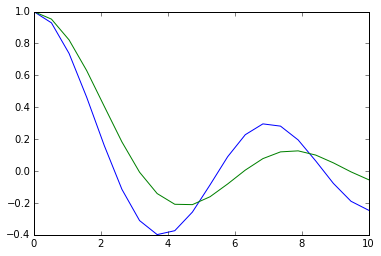

In [259]:
x_arr = np.linspace(0.01, 10, 20)
j0x = [j0(x) for x in x_arr]
sincx = [np.sin(x)/x for x in x_arr]
plt.plot(x, j0x)
plt.plot(x, sincx)

In [250]:
print(zpd_sp(0.01)/0.01)
print(zpd_sp)

(-199.960002667-3.54455322876j)
<function zpd_sp at 0x10a8a2620>


In [251]:
z, wc, l, n, t, al_ratio = 0.01, 1.2, 6.7, 0, 1, ant_rad/ant_len
print(za_l_integrand(z, wc, l, n, t))
print(za_l_integrand_sp(z, wc, l, n, t))
print(za_l_integrand_fast(z, wc, l, n, t, al_ratio))

(13.7897746324635 - 3.39387526419226e-5j)
(13.7897746325-3.39387526419e-05j)
(13.7897746325-3.39387526419e-05j)


In [252]:
    #@timing
    def za_l(wc, l, n, t, tc):
        """
        Longitudinal impedance in unit of Ohms.
        wc: w/w_pc, where w_pc is core electron plasma frequency.
        tc: core electron temperature.
        """
        limits = p.long_interval(wc, n, t)
        print(limits)
        result = mp.quad(lambda z: p.za_l_integrand(z, wc, l, n, t), limits)
        return result 
    #@timing
    def za_l_sp(wc, l, n, t, tc):
        """
        Longitudinal impedance in unit of Ohms.
        wc: w/w_pc, where w_pc is core electron plasma frequency.
        tc: core electron temperature.
        """
        limits = long_interval_sp(wc, n, t)
        print(limits)
        if len(limits) == 2:
            intgrl = scipy.integrate.quad(
                lambda z: za_l_integrand_sp(z, wc, l, n, t), 0, np.inf, limit=100)
            result = intgrl[0]
        if len(limits) == 3:
            sing = limits[1]
            intgrl_1 = scipy.integrate.quad(
                lambda z: za_l_integrand_sp(z, wc, l, n, t), 0, 2 * sing, points = [sing], limit=200)
            print(intgrl_1)
            intgrl_2 = scipy.integrate.quad(
                lambda z: za_l_integrand_sp(z, wc, l, n, t), 2 * sing, np.inf)
            result = intgrl_1[0] + intgrl_2[0]
        return result

In [182]:
mp.quad(lambda z: p.za_l_integrand(z, wc, l, n, t), [0.01, 10])

mpc(real='0.68904477857208901', imag='-0.24902047322755577')

In [243]:
z, wc, l, n, t, tc = 5.1, .5, 6.7, 0.1, 10, 1
scipy.integrate.quad(
    lambda z: np.real(za_l_integrand_sp(z, wc, l, n, t)), 0.1, 10)

(0.35865668708506054, 2.997505792535022e-13)

In [244]:
# plot za for small z
z_list = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.5,0.7, 0.9, 
          1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.8, 2, 2.5, 3, 4, 5, 6, 7, 8, 10, 15, 20, 25, 30, 40, 50, 60, 100]
za_l_integrand_list = [np.real(za_l_integrand_sp(z, wc, l, n, t)) for z in z_list]
d_l_list = [d_l_sp(z, wc, n, t) for z in z_list]
f1_kl = [f1_sp(wc*l/np.sqrt(2)/z) for z in z_list]

In [245]:
d_l_sp(0.01, wc, 0.1, 10)

(1.0008078398506672+1.4223052396393321e-05j)

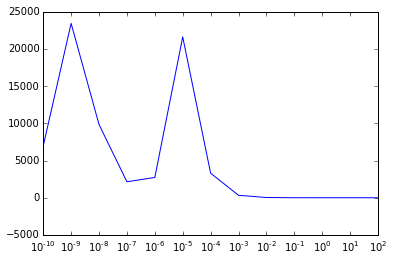

In [247]:
plt.plot(z_list, za_l_integrand_list)
#plt.plot(z_list, np.real(d_l_list))
#plt.plot(z_list, f1_kl)
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [198]:
z, wc, l, n, t, tc = 5.1, .1, 6.7, 0, 1, 1
print(za_l(wc, l, n, t, tc))
za_l_sp(wc, l, n, t, tc)

[0, mpf('+inf')]
(17.3541004048403 - 0.0825616176127433j)

/usr/local/lib/python3.4/site-packages/scipy/integrate/quadpack.py:378: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.4/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)



long_interval_sp function took 0.015 ms
[0, inf]


17.356158064242116

In [123]:
za_l_sp(wc, l, n, t, tc)

/usr/local/lib/python3.4/site-packages/scipy/integrate/quadpack.py:386: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagpe(func,a,b,the_points,args,full_output,epsabs,epsrel,limit)
/usr/local/lib/python3.4/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


3.50200272372
(3.45207030162424 - 0.00720831828234414j)
long_interval_sp function took 5.982 ms
[0, mpf('3.4520703016242407'), mpf('+inf')]
(1.5775455207467586, 1.754594418879938e-05)
za_l_sp function took 321.718 ms


/usr/local/lib/python3.4/site-packages/scipy/integrate/quadpack.py:378: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)


1.5860654483435699

In [ ]:


@timing
def mp_quad(a, b):
    return mp.quad(lambda z: zpd_sp(float(z)), [a, b])

@timing
def sp_quad(a, b):
    return scipy.integrate.quad(lambda z: np.imag(zpd_sp(z)), a, b)

a, b = 0, 10
mp_quad(a, b)
sp_quad(a, b)

In [ ]:
sp_quad(0, 1)